# Understanding the Labour Market of India

## Dataset : [Aspiring Minds' AMCAT 2015 Results](http://ikdd.acm.org/Site/CoDS2016/downloaddataset.html)


Full Pipeline for the testing and training process

In [10]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import xlsxwriter
from xlsxwriter.utility import xl_rowcol_to_cell

# convert T/F to 1/0
def convertTF(df,featureList):
    d = {True:1, False:0}
    for feature in featureList:
        df[feature] = df[feature].apply(lambda x: d[x])
    return df

def yearReturn(x):
    return x.year

def pos(x):
    if x > 0: 
        return 1
    else:
        return 0
def neg(x):
    if x < 0:
        return 1
    else:
        return 0

def val(x):
    if x > 0.44:
        return 3
    elif x < -0.44:
        return 1
    else:
        return 2

def conv_english(x) :
    if x >= 520:
        return 3
    elif x < 420:
        return 1
    else:
        return 2

def conv_logical(x) :
    if x >= 600:
        return 3
    elif x < 450:
        return 1
    else:
        return 2
    
def conv_quant(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def conv_prog(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def gpaCal(x):
    if x <= 10:
        return x*10
    else:
        return x
    
def isNationalBoard(row):
    if (row['isCbse'] or row['isISC'] or row['isICSE']):
        return 1
    else:
        return 0

def prepare(ds):
    ## extracting designation features from designation string
    ds['isSenior'] = ds.Designation.str.contains('senior')
    ds['isSoftware'] = ds.Designation.str.contains('software')
    ds['isManager'] = ds.Designation.str.contains('manager')
    ds['isEngineer'] = ds.Designation.str.contains('engineer')
    ds['isDeveloper'] = ds.Designation.str.contains('developer')
    
    ## extracting degree features into boolean vectors
    ds['isBtech'] = ds.Degree.str.contains('B.Tech/B.E.')
    ds['isMCA'] = ds.Degree.str.contains('MCA')
    ds['isMtech'] = ds.Degree.str.contains('M.Tech./M.E.')
    
    ## extract the board information
    ds['isCbse'] = ds['12board'].str.contains('cbse')
    ds['isStateBoard'] = ds['12board'].str.contains('state board')
    ds['isISC'] = ds['12board'].str.contains('isc')
    ds['isICSE'] = ds['12board'].str.contains('icse')
    ds['isCbse'].fillna(value = False, inplace = True)
    ds['isStateBoard'].fillna(value = False, inplace = True)
    ds['isISC'].fillna(value = False, inplace = True)
    ds['isICSE'].fillna(value = False, inplace = True)
    ds['isNationalBoard'] = 0
    ds['isNationalBoard'] = ds.apply(lambda x : isNationalBoard(x), axis=1)
    
    
    ## extract the specialization information
    ds['isCSE'] = ds.Specialization.str.contains('computer engineering')
    ds['isECE'] = ds.Specialization.str.contains('electronics and communication engineering')
    ds['isIT'] = ds.Specialization.str.contains('information technology')
    ds['isMech'] = ds.Specialization.str.contains('mechanical engineering')
    ds['isICE'] = ds.Specialization.str.contains('instrumentation and control engineering')
    ds['isEE'] = ds.Specialization.str.contains('electrical engineering')
    
    ds = convertTF(ds, ['isCbse', 'isStateBoard', 'isISC', 'isICSE', 'isBtech', 'isMCA', 'isMtech', 'isSenior', 'isSoftware', 'isManager', 'isEngineer', 'isDeveloper','isCSE', 'isECE', 'isIT', 'isMech', 'isICE', 'isEE'])
    
    ## Cleaning the data

    #train.ComputerProgramming.replace(-1,None, inplace=True)
    m = ds.ComputerProgramming.mean(skipna=True)
    ds.ComputerProgramming.fillna(m, inplace=True)

    #train.Domain.replace(-1, None, inplace=True)
    n = ds.Domain.mean(skipna=True)
    ds.Domain.fillna(n, inplace=True)

    ds.GraduationYear.replace(0,None,inplace=True)
    m = ds.GraduationYear.mean(skipna=True)
    ds.GraduationYear.fillna(m, inplace=True)
    
    # Mining different features

    #MaxDomain : max of the domains in one column
    ds['maxDomain'] = ds[['ComputerProgramming','ComputerScience','ElectronicsAndSemicon','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']].max(axis=1)

    # diffGrad : difference between Graduation Year & 12th graduation, to see whether drop in college affect scores
    ds['diffGrad'] = ds.GraduationYear - ds['12graduation']

    # diffGradDOB : difference between Graduation Year and DOB

    ds['DOBY'] = ds.DOB.apply(yearReturn)
    ds['diffGradDOB'] = ds.GraduationYear - ds.DOBY
    
    # Big Five scores
    ds['bigfive'] = 0
    ds.bigfive += ds.agreeableness.apply(lambda x : val(x))
    ds.bigfive += ds.conscientiousness.apply(lambda x : val(x))
    ds.bigfive += ds.nueroticism.apply(lambda x : val(x))
    ds.bigfive += ds.extraversion.apply(lambda x : val(x))
    ds.bigfive += ds.openess_to_experience.apply(lambda x : val(x))
    
    # Translate English / Logical / Quants scores
    ds['scores'] = 0
    ds['scores'] += ds.English.apply(lambda x : conv_english(x))
    ds['scores'] += ds.Logical.apply(lambda x : conv_logical(x))
    ds['scores'] += ds.Quant.apply(lambda x : conv_quant(x))
    ds['scores'] += ds.ComputerProgramming.apply(lambda x : conv_prog(x))
    
    # Fix GPA to 100 scale
    ds['mcolgGPA'] = ds.collegeGPA.apply(lambda x: gpaCal(x))
    
    #Feature columns to take
    feature_cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']
    
    #X & Y vals
    X = ds[feature_cols]
    y = ds.Salary
    
    return X,y

def display_metrics(y_test, y_pred):
    print "MAE : %f" % metrics.mean_absolute_error(y_test, y_pred)
    print "MSE : %f" % metrics.mean_squared_error(y_test, y_pred)
    print "RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print "\n"

def model_train(model,X,y):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
def training(X,y):
    
    #SVM Regression
    svm_clf = svm.SVR()
    print "SVM Regression"
    model_train(svm_clf, X, y)
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 1500,max_features='sqrt')
    print "Random Forests"
    model_train(rand_clf, X, y)
    
    #Linear SVM Regression
    linear_svm_clf = svm.LinearSVR()
    print "Linear SVM Regression"
    model_train(linear_svm_clf, X, y)
    
    #Lasso Regression
    lasso_clf = linear_model.Lasso(alpha=0.01, selection="random", random_state=1)
    print "Lasso Regression"
    model_train(lasso_clf, X, y)
    
    #Linear Regression
    linear_clf = LinearRegression()
    print "Linear Regression"
    model_train(linear_clf, X, y)
    
    #Logistic Regression
    logistic_clf = linear_model.LogisticRegression()
    print "Logistic Regression"
    model_train(logistic_clf, X, y)
    
    return svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf


def testing(X, model, ds, file_name):
    #run model on testing & save submission
    y_pred = model.predict(X)
    submission = pd.DataFrame(columns=['ID','Salary'])
    submission.ID = ds.ID
    submission.Salary = y_pred
    writer_orig = pd.ExcelWriter(file_name, engine='xlsxwriter')
    submission.to_excel(writer_orig, index=False, sheet_name='report')
    writer_orig.save()    
    
    

Loading Data and creating the models

In [11]:
train  = pd.read_excel('train.xlsx', na_values=-1)
print(train.shape)

X, y = prepare(train)
svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf = training(X, y)

(3998, 38)
SVM Regression
MAE : 125660.925009
MSE : 53437895414.849205
RMSE : 231166.380373


Random Forests
MAE : 111257.610000
MSE : 47975365376.411110
RMSE : 219032.795208


Linear SVM Regression
MAE : 116221.915291
MSE : 52165410961.593903
RMSE : 228397.484578


Lasso Regression
MAE : 109380.384031
MSE : 47409688565.939278
RMSE : 217737.659962


Linear Regression
MAE : 109380.399608
MSE : 47409694041.464890
RMSE : 217737.672536


Logistic Regression
MAE : 126116.000000
MSE : 72373996000.000000
RMSE : 269024.155049




As we can see, the least RMSE was reported by **Lasso Regression**. We perform the final prediction on the test set using it : 

In [179]:
test  = pd.read_excel('test.xlsx', na_values=-1)
print(test.shape)

X, y = prepare(test)
testing(X, lasso_clf, test, 'submission.xlsx')

(1500, 38)


## Experimental

Trying out Neural Networks

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)
from sklearn.preprocessing import MinMaxScaler

m1 = MinMaxScaler(feature_range=(0.0, 1.0))
m2 = MinMaxScaler(feature_range=(0.0, 1.0))
m3 = MinMaxScaler(feature_range=(0.0, 1.0))
m4 = MinMaxScaler(feature_range=(0.0, 1.0))
X_train_minmax = m1.fit_transform(X_train)
y_train_minmax = m2.fit_transform(y_train.reshape(-1,1))
X_test_minmax = m3.fit_transform(X_test)
y_test_minmax = m4.fit_transform(y_test.reshape(-1,1))

In [112]:
from sknn import mlp
from sknn.mlp import Layer

clf = mlp.Regressor(layers=[
        Layer("Rectifier", units=2000),
        Layer("Linear")],
    learning_rate=0.00002,
    n_iter=1000)

clf.fit(X_train_minmax, y_train_minmax)

Regressor(batch_size=1, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: units=1000, name=u'hidden0', frozen=False>,
     layers=[<sknn.nn.Layer `Rectifier`: units=1000, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=2e-05, learning_rule=u'sgd',
     loss_type=None, n_iter=1000, n_stable=10,
     output=<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>,
     random_state=None, regularize=None, valid_set=None, valid_size=0.0,
     verbose=None, warning=None, weight_decay=None, weights=None)

In [113]:
y_pr = clf.predict(X_test_minmax)

In [114]:
y_p1 = m4.inverse_transform(y_pr)

In [115]:
display_metrics(y_test,y_p1)

MAE : 118944.466160
MSE : 52788382893.418633
RMSE : 229757.225987




Scores are not that good. Maybe more Layers are needed.

## Visualizations

/home/koustuv/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/koustuv/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


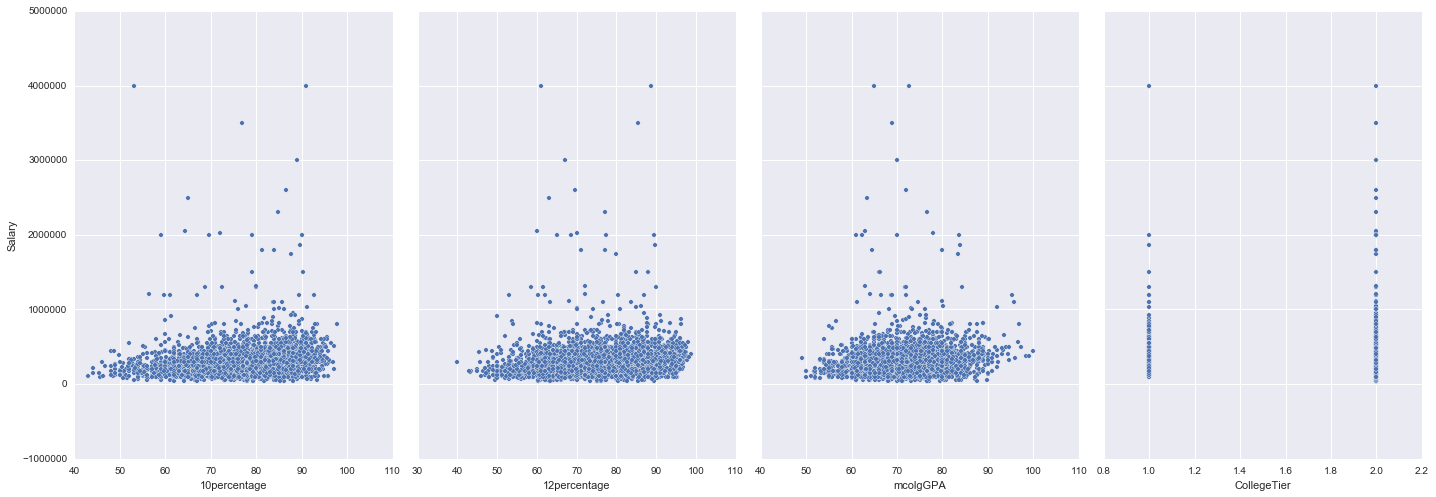

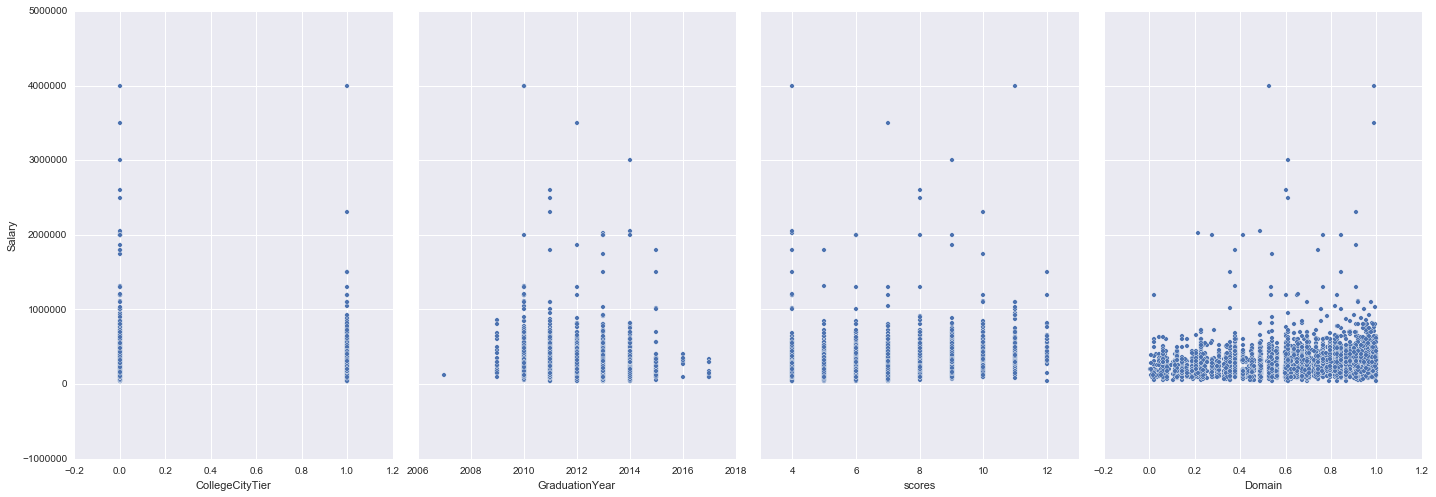

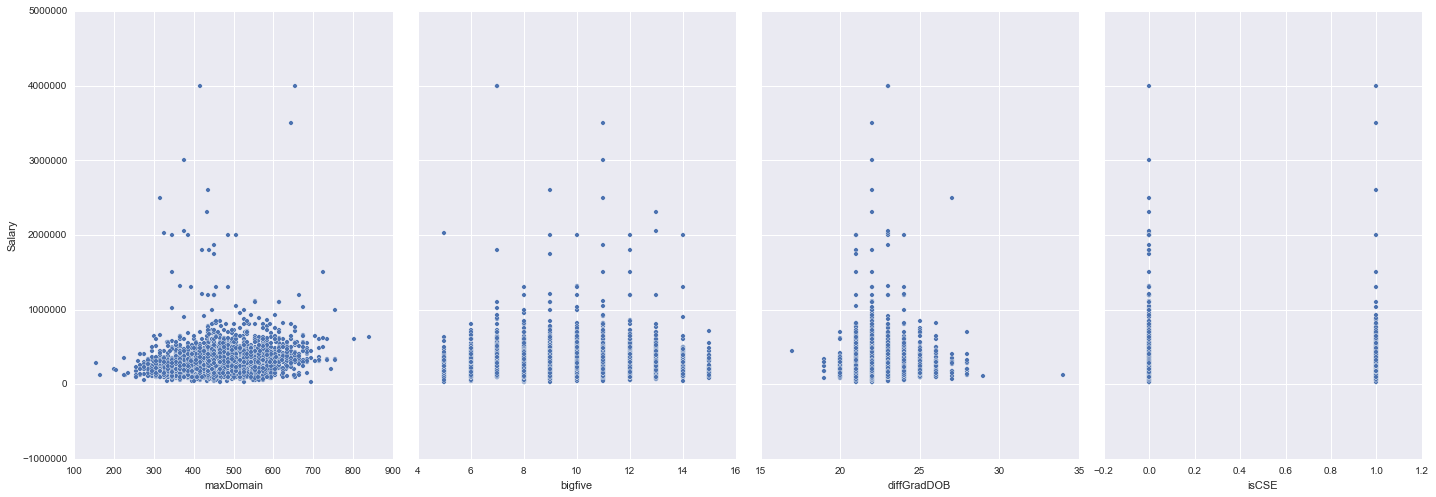

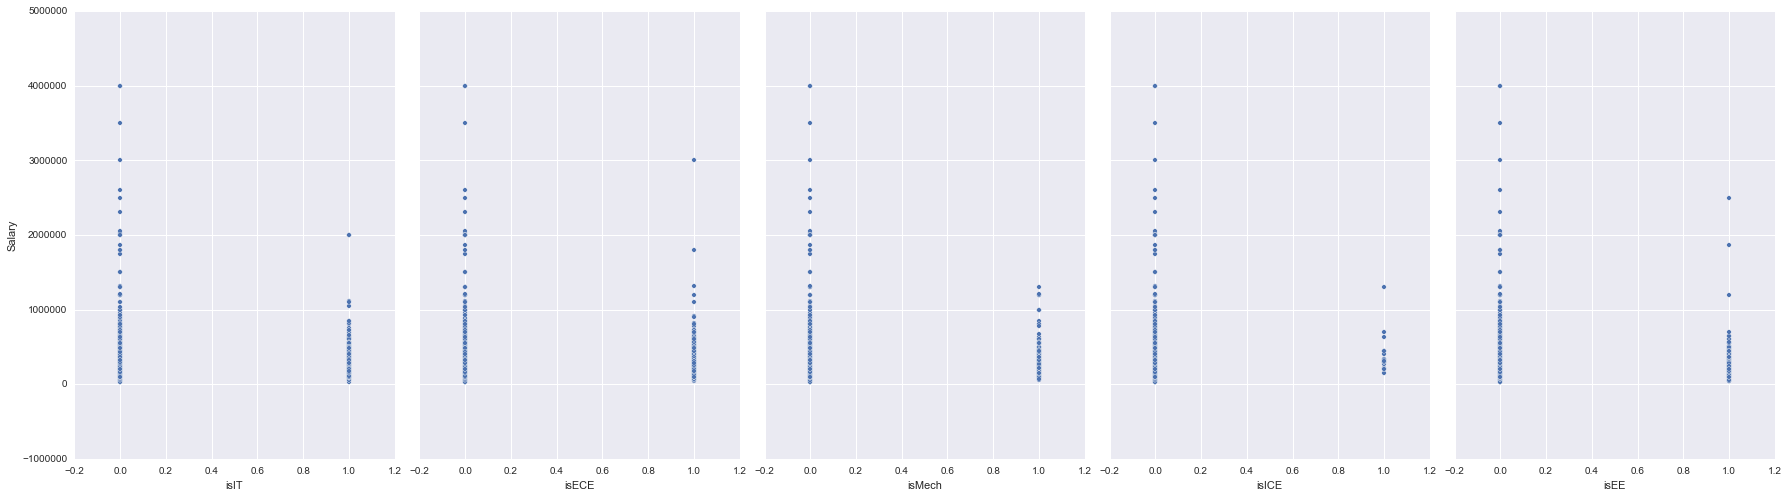

In [3]:
import seaborn as sns
%matplotlib inline

#cols = ['openess_to_experience', 'conscientiousness', 'agreeableness', 'extraversion', 'nueroticism']
#cols = ['maxDomain','Quant','Logical','English']
#cols = ['scores', 'CollegeCityTier', 'isNationalBoard']
cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']

sns.pairplot(train, x_vars = cols[:4], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[4:8], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[8:12], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[12:], y_vars = 'Salary', size = 7, aspect = 0.7)

### Salary Distribution

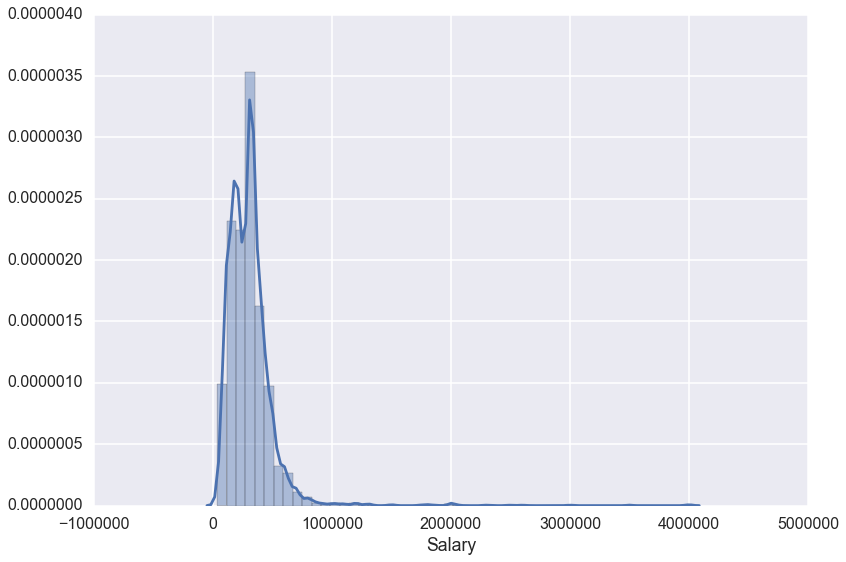

In [9]:
## Histogram of Salary
sns.set_context("poster")
sns.distplot(train.Salary)

## Visualization on dependent variables

First we correct the city information to generate location based insights

In [209]:
train  = pd.read_excel('train.xlsx', na_values=-1)

In [210]:
train.JobCity = train.JobCity.str.lower()

In [211]:
train.JobCity = train.JobCity.str.rstrip()
train.JobCity = train.JobCity.str.lstrip()

In [212]:
# City cleaning process
train.JobCity = train.JobCity.str.replace('banglore','bangalore')
train.JobCity = train.JobCity.str.replace('delhi','new delhi')
train.JobCity = train.JobCity.str.replace('new dehli','new delhi')
train.JobCity = train.JobCity.str.replace('new delhi/ncr','new delhi')
train.JobCity = train.JobCity.str.replace('ncr','new delhi')
train.JobCity = train.JobCity.str.replace('navi mumbai','mumbai')
train.JobCity = train.JobCity.str.replace('mumbai , hyderabad','mumbai')
train.JobCity = train.JobCity.str.replace('new new delhi','new delhi')
train.JobCity = train.JobCity.str.replace('asifabadbangalore','bangalore')
train.JobCity = train.JobCity.str.replace('bengaluru','bangalore')
train.JobCity = train.JobCity.str.replace('greater noida','noida')
train.JobCity = train.JobCity.str.replace('nouda','noida')
train.JobCity = train.JobCity.str.replace('banagalore','bangalore')
train.JobCity = train.JobCity.str.replace('banaglore','bangalore')
train.JobCity = train.JobCity.str.replace('a-64,sec-64,noida','noida')
train.JobCity = train.JobCity.str.replace('technopark, trivandrum','trivandrum')
train.JobCity = train.JobCity.str.replace('vizag','visakhapatnam')
train.JobCity = train.JobCity.str.replace('vsakhapttnam','visakhapatnam')
train.JobCity = train.JobCity.str.replace('thiruvananthapuram','trivandrum')
train.JobCity = train.JobCity.str.replace('ambala city','ambala')
train.JobCity = train.JobCity.str.replace('kudankulam ,tarapur','kundankulam')
train.JobCity = train.JobCity.str.replace('gaziabaad','ghaziabad')
train.JobCity = train.JobCity.str.replace('gajiabaad','ghaziabad')
train.JobCity = train.JobCity.str.replace('bhubaneswar','bhubaneshwar')
train.JobCity = train.JobCity.str.replace('bhubneshwar','bhubaneshwar')
train.JobCity = train.JobCity.str.replace('guragaon','gurgaon')
train.JobCity = train.JobCity.str.replace('gurgoan','gurgaon')
train.JobCity = train.JobCity.str.replace('kolkata`','kolkata')
train.JobCity = train.JobCity.str.replace('sonepat','sonipat')
train.JobCity = train.JobCity.str.replace('baroda','vadodara')
train.JobCity = train.JobCity.str.replace('hderabad','hyderabad')
train.JobCity = train.JobCity.str.replace('pondi','pondy')
train.JobCity = train.JobCity.str.replace('punchkula','panchkula')
train.JobCity = train.JobCity.str.replace('muzzafarpur','muzaffarpur')
train.JobCity = train.JobCity.str.replace('kochi/cochin, chennai and coimbatore','kochi/cochin')
train.JobCity = train.JobCity.str.replace('nasikcity','nashik')
train.JobCity = train.JobCity.str.replace('sahibabad','shahibabad')
train.JobCity = train.JobCity.str.replace('punr','pune')
train.JobCity = train.JobCity.str.replace('tirupati','tirupathi')
train.JobCity = train.JobCity.str.replace('sadulpur,rajgarh,distt-churu,rajasthan','sadulpur')

In [214]:
train.JobCity.value_counts()

bangalore                687
noida                    420
hyderabad                369
pune                     328
chennai                  313
new delhi                228
gurgaon                  222
mumbai                   154
kolkata                  120
jaipur                    53
lucknow                   41
mysore                    40
bhubaneshwar              40
chandigarh                28
indore                    25
coimbatore                21
ahmedabad                 19
bhopal                    19
faridabad                 18
trivandrum                18
ghaziabad                 18
kochi/cochin              14
mohali                    13
nagpur                    11
dehradun                  11
mangalore                 11
visakhapatnam             11
kanpur                     9
jabalpur                   7
nashik                     7
                        ... 
asansol                    1
dharmapuri                 1
dausa                      1
karad         

### Converting City Information to Location Coordinates

We create a new Dataframe to get the city location coordinates

In [216]:
viz = pd.DataFrame({'count' : train.groupby(train.JobCity).size(),
                    'english' : train.groupby(train.JobCity).English.mean(), 
                    'quant' : train.groupby(train.JobCity).Quant.mean(),
                    'logical' : train.groupby(train.JobCity).Logical.mean(),
                    'programming' : train.groupby(train.JobCity).ComputerProgramming.mean()
                   }).reset_index()


Query Google API's to get lattitude and longitude

In [218]:
import urllib
import simplejson
from IPython.display import clear_output
import time

googleGeocodeUrl = 'http://maps.googleapis.com/maps/api/geocode/json?'

def get_coordinates(query, from_sensor=False):
    latitude, longitude = None, None
    if isinstance(query, basestring):
        query = query.encode('utf-8')
        params = {
            'address': query,
            'sensor': "true" if from_sensor else "false"
        }
        url = googleGeocodeUrl + urllib.urlencode(params)
        json_response = urllib.urlopen(url)
        response = simplejson.loads(json_response.read())
        if response['results']:
            location = response['results'][0]['geometry']['location']
            latitude, longitude = round(location['lat'],3), round(location['lng'],3)
            print query, latitude, longitude
        else:
            print query, "<no results>"
    time.sleep(1)
    clear_output()
    return [latitude, longitude]

In [220]:
## get all city coordinates and store them in a new column
viz['JobCityCoords'] = 0

viz.JobCityCoords = viz.JobCity.apply(lambda x : get_coordinates(x))

In [223]:
viz['city_lat'] = viz.JobCityCoords.apply(lambda x : x[0])
viz['city_lon'] = viz.JobCityCoords.apply(lambda x : x[1])

In [224]:
viz

,JobCity,count,english,logical,programming,quant,JobCityCoords,city_lat,city_lon
0,agra,2,445.000000,482.500000,575.000000,442.500000,"[27.177, 78.008]",27.177,78.008
1,ahmedabad,19,530.736842,535.263158,491.428571,522.052632,"[23.023, 72.571]",23.023,72.571
2,ahmednagar,2,535.000000,505.000000,345.000000,480.000000,"[19.095, 74.75]",19.095,74.750
3,"al jubail,saudi arabia",1,325.000000,335.000000,385.000000,525.000000,"[26.96, 49.569]",26.960,49.569
4,allahabad,1,335.000000,495.000000,NaN,475.000000,"[25.436, 81.846]",25.436,81.846
5,alwar,1,500.000000,350.000000,315.000000,400.000000,"[27.553, 76.635]",27.553,76.635
6,am,1,375.000000,245.000000,125.000000,295.000000,"[-3.417, -65.856]",-3.417,-65.856
7,ambala,3,498.333333,543.333333,431.666667,561.666667,"[30.378, 76.777]",30.378,76.777
8,angul,1,595.000000,365.000000,455.000000,705.000000,"[20.844, 85.151]",20.844,85.151
9,ariyalur,1,305.000000,435.000000,445.000000,295.000000,"[11.14, 79.079]",11.140,79.079


In [225]:
writer_orig = pd.ExcelWriter('vizualization_data.xlsx', engine='xlsxwriter')
viz.to_excel(writer_orig, index=False, sheet_name='viz')
writer_orig.save()

## Few more Visualizations

### Salary to Big Five

TypeError: annotate() argument after ** must be a mapping, not bool

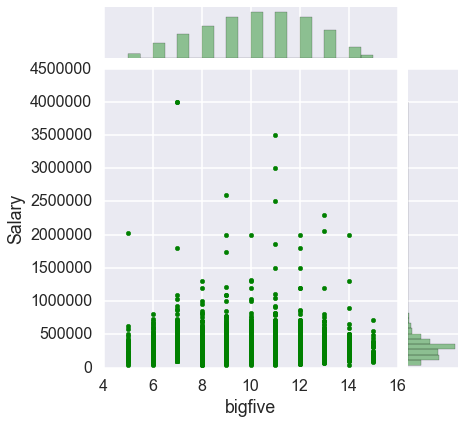

In [5]:
import seaborn as sns
%matplotlib inline

df = train[['Salary','bigfive']]
sns.set_context("poster")
sns.jointplot(x='bigfive', y='Salary', data=df, color="g",annot_kws=False)

### Top Job Designations

Clubbing few similar designations

In [11]:
## Clubbing of Designations into similar ones
train.Designation = train.Designation.str.replace("software test engineer","STE")
train.Designation = train.Designation.str.replace("test engineer","STE")
train.Designation = train.Designation.str.replace("STE","software test engineer")
train.Designation = train.Designation.str.replace("system engineer","systems engineer")
train.Designation = train.Designation.str.replace("associate software engineer","software engineer")
train.Designation = train.Designation.str.replace("software developer","software engineer")
train.Designation = train.Designation.str.replace("java software engineer","java developer")

In [12]:
vc = train.Designation.value_counts()
print vc[vc > 30]

software engineer             850
systems engineer              323
java developer                178
software test engineer        157
programmer analyst            139
senior software engineer       92
project engineer               77
technical support engineer     76
web developer                  54
application developer          52
assistant manager              52
network engineer               51
data analyst                   49
business analyst               49
engineer                       47
android developer              46
programmer                     36
senior systems engineer        35
.net developer                 34
php developer                  33
Name: Designation, dtype: int64


(-1.0923574539613885,
 1.0002072160862239,
 -1.0024863013772434,
 1.0530266963411072)

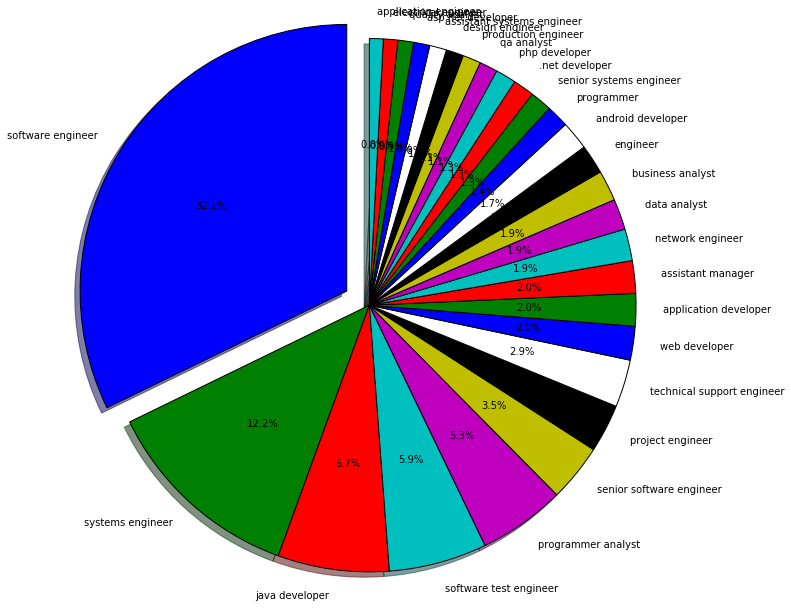

In [48]:
vd = vc[vc > 20].reset_index()
labels = vd['index']
explode = np.zeros(vd.shape[0])
explode[0] = 0.1
# print explode

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(10,10)

plt.pie(vd['Designation'], labels=labels, explode = explode,
        autopct='%1.1f%%', shadow=True, startangle=90)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
# plt.legend(patches, labels)

In [57]:
grp = train.groupby('Designation')['ComputerProgramming'].agg({'mean' : np.mean, 'std' : np.std,'count' : lambda ts: (ts > 0).sum()})
quants = grp[grp['count'] > 30].sort_values(by='count',ascending=False)['mean']

### College Tier and College City Tier Distributions

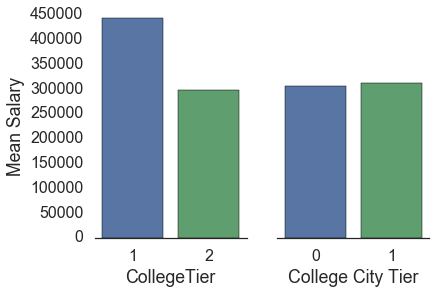

In [117]:
#gr = train.groupby('CollegeTier')['Salary'].agg({'mean' : np.mean, 'std' : np.std})
#gr.reset_index(inplace=True)
gd = train.groupby('CollegeCityTier')['Salary'].agg({'mean' : np.mean, 'std' : np.std})
gd.reset_index(inplace=True)
sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
side_plot = sns.barplot(x="CollegeTier",y="mean",data=gr, ax=ax1)
bottom_plot = sns.barplot(x="CollegeCityTier", y="mean", data=gd,ax=ax2)
#topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
#bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
#l = plt.legend([bottombar, topbar], ['Bottom Bar', 'Top Bar'], loc=1, ncol = 2, prop={'size':16})
#l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
side_plot.set_ylabel("Mean Salary")
bottom_plot.set_ylabel("")
bottom_plot.set_xlabel("College City Tier")

### Specializations Distributions

Clubbing few similar specializations

In [141]:
train.Specialization = train.Specialization.str.replace('computer application','C.S.E')
train.Specialization = train.Specialization.str.replace('computer engineering','C.S.E')
train.Specialization = train.Specialization.str.replace('C.S.E','computer science & engineering')
train.Specialization = train.Specialization.str.replace('electronics & instrumentation eng','electronics and instrumentation engineering')

In [142]:
ge = train.groupby('Specialization')['Salary'].agg({'mean' : np.mean, 'std' : np.std, 'count' : lambda ts: (ts > 0).sum(), 'max' : np.max})
ge.reset_index(inplace=True)
fd = ge.sort_values(by='max',ascending=False)[0:10]
fd

,Specialization,std,count,max,mean
11,computer science & engineering,246405.035066,1588,4000000,314414
18,electronics and communication engineering,174908.017635,880,3000000,296812
20,electronics and electrical engineering,216227.652179,196,2500000,286913
21,electronics and instrumentation engineering,343179.068671,59,2300000,347542
30,information technology,176776.373234,660,2000000,308492
15,electrical engineering,216095.487832,82,1860000,293780
36,mechanical engineering,211993.536347,201,1300000,317457
31,instrumentation and control engineering,252579.325736,20,1300000,394000
1,applied electronics and instrumentation,236973.099739,9,950000,348333
7,civil engineering,190528.659132,29,800000,381206


In [143]:
fd.Specialization = fd.Specialization.str.replace("computer science & engineering","CSE")
fd.Specialization = fd.Specialization.str.replace("electronics and communication engineering","ECE")
fd.Specialization = fd.Specialization.str.replace("electronics and electrical engineering","EEE")
fd.Specialization = fd.Specialization.str.replace("electronics & instrumentation eng","EIE")
fd.Specialization = fd.Specialization.str.replace("information technology","IT")
fd.Specialization = fd.Specialization.str.replace("electrical engineering","EE")
fd.Specialization = fd.Specialization.str.replace("mechanical engineering","ME")
fd.Specialization = fd.Specialization.str.replace("instrumentation and control engineering","ICE")
fd.Specialization = fd.Specialization.str.replace("applied electronics and instrumentation","AEI")
fd.Specialization = fd.Specialization.str.replace("civil engineering","CE")

In [145]:
fd.Specialization = fd.Specialization.str.replace("electronics and instrumentation engineering","EIE")
fd

,Specialization,std,count,max,mean
11,CSE,246405.035066,1588,4000000,314414
18,ECE,174908.017635,880,3000000,296812
20,EEE,216227.652179,196,2500000,286913
21,EIE,343179.068671,59,2300000,347542
30,IT,176776.373234,660,2000000,308492
15,EE,216095.487832,82,1860000,293780
36,ME,211993.536347,201,1300000,317457
31,ICE,252579.325736,20,1300000,394000
1,AEI,236973.099739,9,950000,348333
7,CE,190528.659132,29,800000,381206


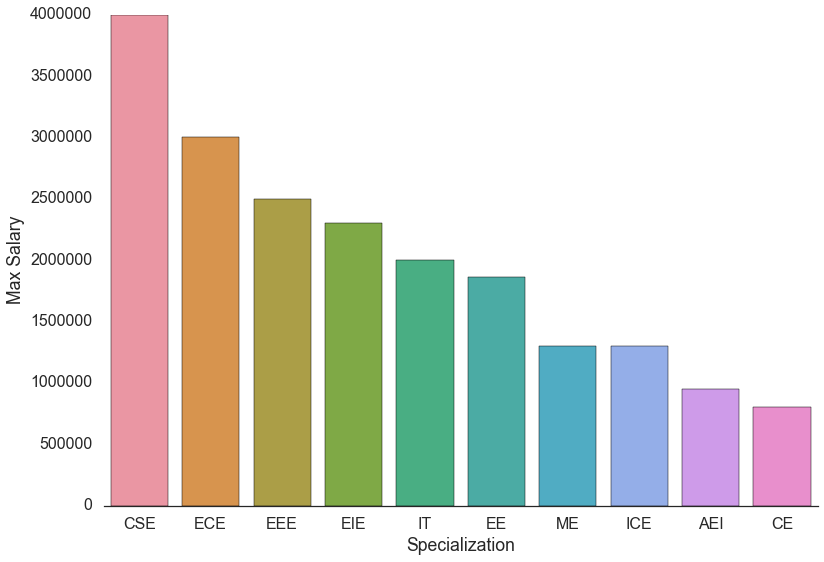

In [149]:
op = sns.barplot(x="Specialization", y="max", data=fd)
sns.set_context("poster")
sns.despine(left=True)
op.set_ylabel("Max Salary")

In [58]:
#df = pd.DataFrame()
df['ComputerProgramming'] = quants

In [73]:
df

,Designation,Quant,English,Logical,ComputerProgramming
0,software engineer,523.952941,504.535294,511.803529,475.347647
1,systems engineer,564.408669,536.343653,529.628483,475.055409
2,java developer,496.915730,490.898876,490.353933,474.239952
3,software test engineer,501.541401,498.197452,492.159236,433.033929
4,programmer analyst,524.733813,518.848921,514.194245,467.513143
5,senior software engineer,564.250000,497.358696,513.619565,486.800167
6,project engineer,541.415584,507.506494,502.467532,451.004245
7,technical support engineer,473.447368,513.144737,483.263158,408.909496
8,web developer,487.407407,467.222222,483.129630,443.731600
9,application developer,553.576923,537.980769,531.153846,475.513683


In [71]:
df.reset_index(inplace=True)

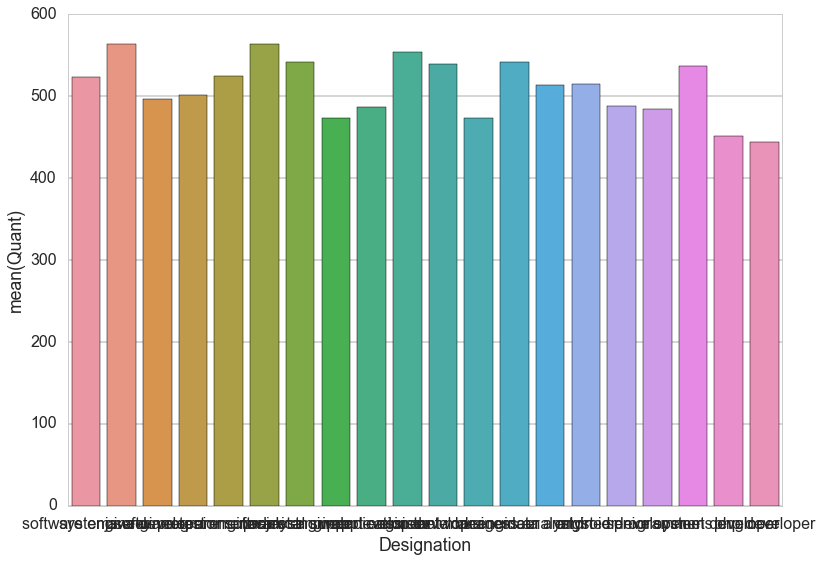

In [76]:
import seaborn as sns

%matplotlib inline

sns.set_context("poster")
sns.set_style("whitegrid")
ax = sns.barplot(x="Designation", y="Quant", data=df)

In [77]:
writer_orig = pd.ExcelWriter('exploration.xlsx', engine='xlsxwriter')
df.to_excel(writer_orig, index=False, sheet_name='report')
writer_orig.save()

### Scores By Designation 

[ 0  2  4  6  8 10 12 14 16 18]


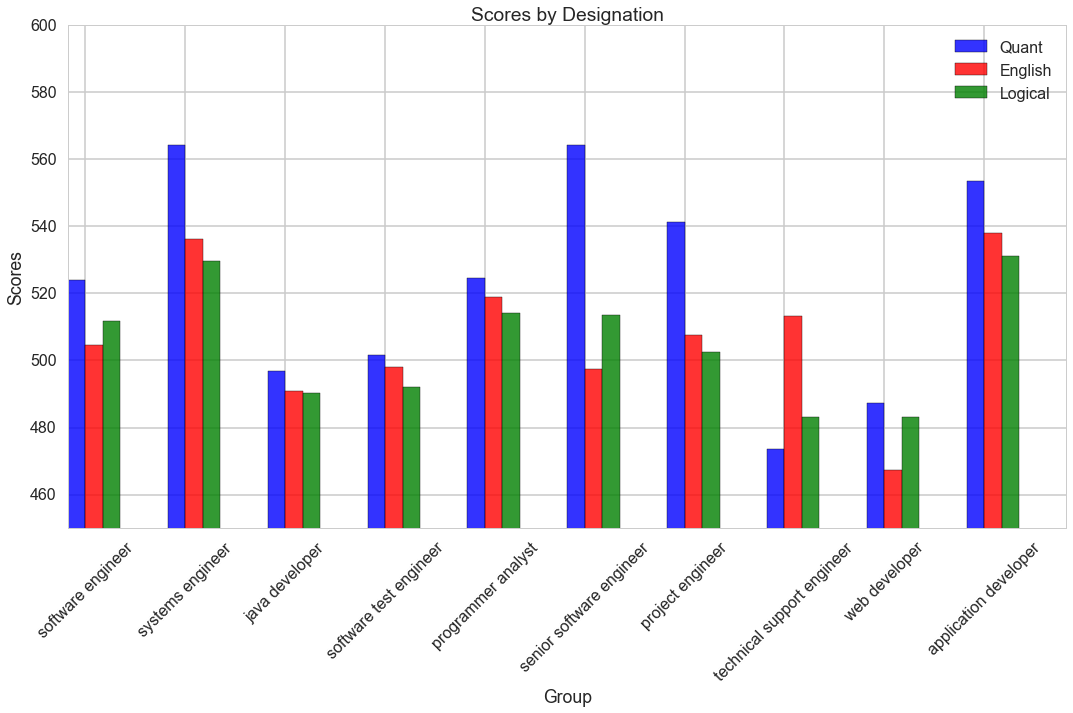

In [99]:
import matplotlib.pyplot as plt

%matplotlib inline

n_groups = 10
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.set(ylim=[450, 600])
index = np.arange(0, n_groups * 2, 2)
print index
bar_width = 0.35
opacity = 0.8
error_config = {'ecolor': '0.3'}

means_men = (20, 35, 30, 35, 27)
means_women = (25, 32, 34, 20, 25)

rects1 = plt.bar(index, df.Quant[0:10], bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='Quant')

rects2 = plt.bar(index + bar_width, df.English[0:10], bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='English')

rects3 = plt.bar(index + bar_width * 2, df.Logical[0:10], bar_width,
                 alpha=opacity,
                 color='g',
                 error_kw=error_config,
                 label='Logical')

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Scores by Designation')
plt.xticks(index + bar_width, df.Designation[0:10], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Spatial Visualizations


In [8]:
viz  = pd.read_excel('vizualization_data.xlsx', na_values=-1)
viz_new = viz[viz['count'] > 20]

In [9]:
import folium

lat = 23.051013
lon = 78.242494

map_osm = folium.Map(location=[lat, lon],tiles='Stamen Toner', zoom_start=5)
fill_color_g = '#FF1A1A'
fill_color_border_g = '#FF2F1A'
fill_color_a = '#ff751a'
fill_color_border_a = '#e65b00'
fill_color_l = '#FFB91A'
fill_color_border_l = '#FF991A'

field = 'quant'
for name, row in viz_new.iterrows():
    fill_color = ''
    line_color = ''
    if int(row[field]) > 520:
        fill_color = fill_color_g
        line_color = fill_color_border_g
    elif int(row[field]) > 500:
        fill_color = fill_color_a
        line_color = fill_color_border_a
    else :
        fill_color = fill_color_l
        line_color = fill_color_border_l
    map_osm.circle_marker(location=[row["city_lat"], row["city_lon"]],radius=(int(row[field]) - 450) * 1000, popup=row["JobCity"], fill_color=fill_color, line_color=line_color)
    #map_osm.simple_marker([row["city_lat"], row["city_lon"]], popup=row["JobCity"])
    map_osm.polygon_marker(location=[row["city_lat"], row["city_lon"]],
                     fill_color=fill_color, num_sides=3, radius=(int(row[field]) - 450) * 0.2)
map_osm.create_map(path='test.html')
map_osm